# Neural Machine Translation by Jointly Learning to Align and Translate(ICLR 2015)
# 2021/04/16
- seq2seq 모델에 attention을 추가한 `seq2seq with attention` 모델을 실습해보았다.
- 기존의 seq2seq 모델은 인코더를 사용하여 context vector에 소스 문장의 정보를 압축하므로 이 과정에서 병목(bottleneck)이 발생하여 성능 하락의 원인이 된다.
- 이를 해결하기 위해 `seq2seq with attention` 모델은 디코더가 단어를 하나 출력할 때마다 소드 문장의 출력 전부를 입력으로 받는다.
- 최신 GPU는 큰 메모리 용량과 빠른 병렬 처리를 지원하므로, 소스 문장이 길더라도 각 단어의 인코더 출력값 전부를 특정 행렬에 기록하였다가 디코더가 각 단어를 출력할 때마다 소스 문장에 대한 정보를 입력해줄 수 있다.
- 이 때 attention 매커니즘을 사용한다.
- Attention 매커니즘에서는 디코더가 단어 하나를 출력할 때마다 출력 단어가 입력 문장에서 어떤 단어와 깊은 연관성을 가지는지를 학습한다.
- 출력 단어와 연관성이 높은 단어를 소스 문장에서 가중치를 통해 찾아 해당 단어를 출력 단어로 번역한다.
- 소스 문장의 단어와 출력 문장의 단어에 대한 연관성을 가중치(확률값)를 통해 표현하므로 학습이 완료되면, 어떤 단어가 어떤 단어와 연관성이 높아 번역되었는지 그리드 그래프로도 표현이 가능하다.
- 이를 통해 짧은 문장은 물론이고, 단어 개수가 50개 이상인 매우 긴 문장에 대해서도 기존의 seq2seq 모델보다 우월한 성능을 보여주었다고 한다.
- 이러한 seq2seq with attention 모델을 아래의 링크를 참조하여 구현해보았다.  
  [papar: Neural Machine Translation by Jointly Learning to Align and Translate (ICLR 2015 Oral)](https://arxiv.org/abs/1409.0473)  
  [Seq2Seq with attention + Transformer review](https://www.youtube.com/watch?v=AA621UofTUA)  
  [Tensorflow tutorial](https://www.tensorflow.org/tutorials/text/nmt_with_attention)

In [1]:
# 사용할 패키지 import
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import unicodedata
import re
import numpy as np
import os
import io
import time

## 데이터 전처리
- http://www.manythings.org/anki/ 에서 제공하는 언어 데이터셋을 사용한다.
- 이 데이터셋은 영어-스페인어 번역의 쌍을 아래와 같은 형태로 포함한다고 한다.  
    May I borrow this book? ¿Puedo tomar prestado este libro?
- 데이터셋을 다운로드한 후에는 아래와 같은 전처리를 거친다.
    1. 각 문장에 <sos>와 <eos> 토큰을 추가한다.
    2. 특정 문자를 제거하여 문장을 정리한다.
    3. 단어 인덱스와 아이디(ID) 인덱스를 생성한다(단어 -> 아이디, 아이디 -> 단어로 매핑된 딕셔너리).
    4. 각 문장에 대해 입력층의 최대 길이만큼 패딩을 수행한다.

In [2]:
# 데이터셋 다운로드
path_to_zip = tf.keras.utils.get_file('spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
                                     extract=True)
path_to_file = os.path.dirname(path_to_zip) + "/spa-eng/spa.txt"

In [3]:
# 유니코드 파일을 아스키 코드 파일로 변환
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    # 단어와 단어 뒤에 오는 구두점(.) 사이에 공백을 생성한다.
    # 예시: "he is a boy." => "he is a boy ."
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # (a-z, A-Z, ".", "?", "!", ",")을 제외한 모든 것을 공백으로 대체한다.
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()
    
    # 모델이 예측을 시작하거나 중단할 때를 알게 하기 위해 문장에 start와 end 토큰을 추가한다.
    w = "<start> " + w + " <end>"
    return w

In [4]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [5]:
# 1. 문장에 있는 억양을 제거한다. -> 마침표 같은 기호에 공백을 추가하여 문장이 
# 어떤 기호로 끝나는지(억양)에 대한 내용을 제거한다는 말인 것 같다. 
# 2. 불필요한 문자를 제거하여 문장을 정리한다.
# 3. word_pairs는 [영어, 스페인어] 형식으로 문장의 쌍을 리턴한다.
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    
    return zip(*word_pairs)

In [6]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


- 데이터셋으로 사용할 문장의 전체 개수는 아래와 같다.

In [7]:
print(len(en))

118964


In [8]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, lang_tokenizer

In [9]:
def load_dataset(path, num_examples=None):
    # 전처리된 타겟 문장과 입력 문장 쌍을 생성한다.
    targ_lang, inp_lang = create_dataset(path, num_examples)
    
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

#### 데이터 크기 제한(선택사항)
- 현재 데이터셋의 문장은 10만개 이상인데, 이를 모두 훈련시키려면 시간이 매우 오래 걸리기 때문에 데이터셋의 크기를 
3만개로 제한하는 코드이다.
- 그러나 데이터셋의 크기는 클수록 좋기 때문에 일단 현재 상태에서 모델을 훈련시켜보고 시간이 너무 오래 걸린다 싶으면 크기를
    줄여보려고 한다.

In [10]:
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [11]:
# 훈련 데이터셋과 검증 데이터셋을 8:2로 분리
X_train, X_valid, y_train, y_valid = train_test_split(input_tensor, target_tensor, test_size=0.2)
print(len(X_train), len(y_train), len(X_valid), len(y_valid))

24000 24000 6000 6000


In [12]:
def convert(lang, tensor):
    for t in tensor:
        if t != 0:
            print(f"{t} ----> {lang.index_word[t]}")

In [13]:
print("Input language; index to word mapping")
convert(inp_lang, X_train[0])
print("")
print("Target language; index to word mapping")
convert(targ_lang, y_train[0])

Input language; index to word mapping
1 ----> <start>
8 ----> no
88 ----> hay
221 ----> agua
3 ----> .
2 ----> <end>

Target language; index to word mapping
1 ----> <start>
57 ----> there
8 ----> is
66 ----> no
258 ----> water
3 ----> .
2 ----> <end>


#### tf.data 데이터셋 생성하기

In [14]:
BUFFER_SIZE = len(X_train)
BATCH_SIZE = 64
steps_per_epoch = len(X_train) // BATCH_SIZE
embedding_dim = 256 # 논문에서는 620차원으로 하였다.
units = 1024
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # drop_remainder 옵션은 마지막 배치의 사이즈가 
                                                         # BATCH_SIZE보다 작을 때 해당 배치를 훈련에 사용하지 않게 할 때 
                                                         # 사용하는 옵션이다.

In [15]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

#### 인코더와 디코더 모델 정의하기

In [16]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz): ## 선언 시 (전체 단어 수, embedding 차원, units, BATCH_SIZE)
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units, 
                                       return_sequences=True, 
                                       return_state=True, 
                                       recurrent_initializer='glorot_uniform')
    
    def call(self, x, hidden):
        x = self.embedding(x)
#         print(x.shape)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [17]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

In [18]:
# return_sequences=True로 지정하여, sample_output의 사이즈에 문장 전체 길이(sequence length)도 포함되어 있는 것을 
# 알 수 있다.
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print(f"Encoder output shape: [batch size, sequence length, units] {sample_output.shape}")
# 이게 의미하는 것은 인코더에 입력된 문장의 마지막 단어에 대한 hidden state이다.
print(f"Encoder hidden state shape: [batch size, units] {sample_hidden.shape}")

Encoder output shape: [batch size, sequence length, units] (64, 16, 1024)
Encoder hidden state shape: [batch size, units] (64, 1024)


In [19]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  2409984   
_________________________________________________________________
gru (GRU)                    multiple                  3938304   
Total params: 6,348,288
Trainable params: 6,348,288
Non-trainable params: 0
_________________________________________________________________


In [20]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.U = tf.keras.layers.Dense(units)
        self.v = tf.keras.layers.Dense(1)
    
    def call(self, query, values):
        # query: 디코더의 매 타임스텝마다의 hidden state, query hidden state shape: [batch size, units]
        # query_with_time_axis shape: [batch size, 1, units]
        # values: 인코더의 출력(hidden state), values shape: [batch size, sequence_length, units]
        query_with_time_axis = tf.expand_dims(query, axis=1) # expand_dims()는 입력한 axis에 차원을 1만큼 증가시킨 
                                                             # 텐서를 리턴한다.
        
        # score shape: [batch size, max_length, 1]
        # self.v() 이전 shape: [batch size, max_length, units]
        score = self.v(tf.nn.tanh(self.W(query_with_time_axis) + self.U(values)))
#         print(self.W(query_with_time_axis).shape)
#         print(self.U(values).shape)
#         print(score.shape)
        # attention_weights shape: [batch size, max_length, 1]
        attention_weights = tf.nn.softmax(score, axis=1)
#         print(attention_weights.shape)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

- 결과를 보면 attention_weights의 shape은 [batch size, sequence_length, 1]임을 알 수 있는데 이는 각 문장을 이루는 단어가
현재 디코더의 출력 단어와 얼마나 연관성을 가지는지를 나타내는 확률값을 나타낸다.
- 이를 인코더의 매 타임스텝마다의 hidden state를 의미하는 encoder output과 곱해 encoder output에 weight를 가한다.
- 그리고 나서 reduce_sum을 하여 context_vector를 구한다.
- 이를 통해 context_vector는 encoder의 output에 weight가 가해진 형태가 되어 입력 문장과 현재 출력 단어의 연관성에 대한
정보를 가지게 된다.

In [21]:
attention_layer = BahdanauAttention(10) # 여기서 10이 의미하는 것은, 디코더가 출력하는 단어가 소스 문장과 얼마나 연관성이
                                        # 있는지를 나타내는 attention_weigths를 계산할 때 사용할 fc층의 units이다.
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)
print(f"Attention weights shape: [batch size, sequence_length, 1] {attention_weights.shape}")
print(f"Attention result shape: [batch size, units] {attention_result.shape}")

Attention weights shape: [batch size, sequence_length, 1] (64, 16, 1)
Attention result shape: [batch size, units] (64, 1024)


In [22]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # 어텐션을 사용한다.
        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape: [batch_size, input_sequence_length, attention_units(= dec_units)]
        context_vector, attention_weights = self.attention(hidden, enc_output)
        
        # embedded x shape: [batch_size, 1, embedding_dim]
        x = self.embedding(x)
        
        # concatenated x shape: [batch_size, 1, embedding_dim + attention_units]
        x = tf.concat([tf.expand_dims(context_vector, axis=1), x], axis=-1)
        
        # 위에서 결합된 벡터 x를 GRU에 전달한다.
        # output shape: [batch_size, 1, dec_units]
        output, state = self.gru(x)
        # print(output.shape)
        
        # reshaped output shape: [batch_size * 1, dec_units]
        output = tf.reshape(output, (-1, output.shape[2]))
        # print(output.shape)
        
        # x shape: [batch_size, vocab_tar_size]
        x = self.fc(output)
        # print(x.shape)
        
        return x, state, attention_weights

In [23]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

# example_target = tf.expand_dims(example_target_batch[:, 1], axis=1)
# sample_decoder_output, _, _ = decoder(example_target, sample_hidden, sample_output)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)
print(f"Decoder output shape: [batch_size, target vocab size] {sample_decoder_output.shape}")

Decoder output shape: [batch_size, target vocab size] (64, 4935)


# 2021/04/18
#### 최적화 함수와 손실 함수 정의하기

In [24]:
# 논문에서는 optimizer로 Adadelta를 사용하였다.
# optimizer = tf.keras.optimizers.Adadelta(rho=0.95, epsilon=1e-06)
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0)) # 실제값 0은 inp_lang.index_word[0]을 하였을 때 존재하지 않는 단어
                                                       # 이므로 loss로 사용하면 안된다. 실제값이 0인 경우 tf.math.equal()
                                                       # 은 True를 리턴하고, tf.math.logical_not()은 True를 False로 변경
                                                       # 하므로 mask에는 real이 0일 때 False가 입력된다.
                                                       # 뒤에서 이 mask는 0으로 변경되고 loss_와 곱해져 loss_를 마스킹한다.
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype) # 데이터형을 변경해주는 함수이다.
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

#### 체크포인트(객체 기반 저장)

In [25]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'chpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

#### 언어 모델 훈련하기
1. 인코더의 output, 인코더 hidden state를 리턴하는 인코더에 소스 문장과 인코더 hidden state를 입력한다.
2. 타겟 문장, 디코더 hidden state 및 어텐션을 통해 context vector를 구할 때 사용되는 인코더의 output을 디코더에 입력한다.
3. 전달 받은 값을 사용하여 디코더는 매 타임스텝마다 예측 단어 및 디코더 hidden state를 리턴한다.
4. 리턴된 디코더 hidden state는 다시 디코더에 입력되고 예측 단어를 사용하여 손실을 계산한다.
5. 디코더에 대한 다음 타임스텝의 타겟 단어는 teacher forcing을 사용하여 결정된다.
6. 마지막 단계에는 그레디언트를 계산하여 이를 optimizer와 역전파에 적용한다.

In [26]:
# encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
# decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        
        dec_hidden = enc_hidden # 인코더의 마지막 hidden state를 디코더의 첫번째 hidden state로 입력한다.
        
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, axis=1)
        
        # teacher_forcing: 다음 입력으로 타겟을 feeding한다.
        for t in range(1, targ.shape[1]): # targ.shape[1]은 타겟 문장의 sequence_length가 된다.
                                          # 훈련 시 디코더에는 타겟 문장의 "<start>" 토큰은 입력하지 않으므로 반복문을
                                          # 1부터 시작한다.
            # enc_output을 디코더에 전달한다.
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            
            # teacher forcing을 사용하여 디코더의 predictions을 다음 입력으로 사용하는 것이 아니라 target 단어를 
            # 다음 입력으로 사용한다.
            dec_input = tf.expand_dims(targ[:, t], axis=1)
        
        batch_loss = (loss / int(targ.shape[1])) # 배치 문장 길이로 loss를 나누어 배치 내 각 문장의 loss 평균을 계산한다.
        
        variables = encoder.trainable_variables + decoder.trainable_variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        return batch_loss

In [27]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
        
        if batch % 100 == 0:
            print(f"Epoch {epoch + 1} Batch {batch} Loss {batch_loss.numpy():.4f}")
        
    # 에포크가 2번 실행될 때마다 모델 저장(체크포인트)
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
        
    print(f"Epoch {epoch + 1} Loss {(total_loss / steps_per_epoch):.4f}")
    print(f"Time taken for 1 epoch {time.time() - start} sec\n")

    def call(self, x, hidden):
        x = self.embedding(x)
#         print(x.shape)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

This may be caused by multiline strings or comments not indented at the same level as the code.
    def call(self, x, hidden):
        x = self.embedding(x)
#         print(x.shape)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

This may be caused by multiline strings or comments not indented at the same level as the code.
    def call(self, query, values):
        # query: 디코더의 매 타임스텝마다의 hidden state, query hidden state shape: [batch size, units]
        # query_with_time_axis shape: [batch size, 1, units]
        # values: 인코더의 출력(hidden state), values shape: [batch size, sequence_length, units]
        query_with_time_axis = tf.expand_dims(query, axis=1) # expand_dims()는 입력한 axis에 차원을 1만큼 증가시킨 
                                                             # 텐서를 리턴한다.
 

    def call(self, query, values):
        # query: 디코더의 매 타임스텝마다의 hidden state, query hidden state shape: [batch size, units]
        # query_with_time_axis shape: [batch size, 1, units]
        # values: 인코더의 출력(hidden state), values shape: [batch size, sequence_length, units]
        query_with_time_axis = tf.expand_dims(query, axis=1) # expand_dims()는 입력한 axis에 차원을 1만큼 증가시킨 
                                                             # 텐서를 리턴한다.
        
        # score shape: [batch size, max_length, 1]
        # self.v() 이전 shape: [batch size, max_length, units]
        score = self.v(tf.nn.tanh(self.W(query_with_time_axis) + self.U(values)))
#         print(self.W(query_with_time_axis).shape)
#         print(self.U(values).shape)
#         print(score.shape)
        # attention_weights shape: [batch size, max_length, 1]
        attention_weights = tf.nn.softmax(score, axis=1)
#         print(attention_weights.shape)
        context_vector = attention_weights * values
        co

    def call(self, query, values):
        # query: 디코더의 매 타임스텝마다의 hidden state, query hidden state shape: [batch size, units]
        # query_with_time_axis shape: [batch size, 1, units]
        # values: 인코더의 출력(hidden state), values shape: [batch size, sequence_length, units]
        query_with_time_axis = tf.expand_dims(query, axis=1) # expand_dims()는 입력한 axis에 차원을 1만큼 증가시킨 
                                                             # 텐서를 리턴한다.
        
        # score shape: [batch size, max_length, 1]
        # self.v() 이전 shape: [batch size, max_length, units]
        score = self.v(tf.nn.tanh(self.W(query_with_time_axis) + self.U(values)))
#         print(self.W(query_with_time_axis).shape)
#         print(self.U(values).shape)
#         print(score.shape)
        # attention_weights shape: [batch size, max_length, 1]
        attention_weights = tf.nn.softmax(score, axis=1)
#         print(attention_weights.shape)
        context_vector = attention_weights * values
        co

    def call(self, query, values):
        # query: 디코더의 매 타임스텝마다의 hidden state, query hidden state shape: [batch size, units]
        # query_with_time_axis shape: [batch size, 1, units]
        # values: 인코더의 출력(hidden state), values shape: [batch size, sequence_length, units]
        query_with_time_axis = tf.expand_dims(query, axis=1) # expand_dims()는 입력한 axis에 차원을 1만큼 증가시킨 
                                                             # 텐서를 리턴한다.
        
        # score shape: [batch size, max_length, 1]
        # self.v() 이전 shape: [batch size, max_length, units]
        score = self.v(tf.nn.tanh(self.W(query_with_time_axis) + self.U(values)))
#         print(self.W(query_with_time_axis).shape)
#         print(self.U(values).shape)
#         print(score.shape)
        # attention_weights shape: [batch size, max_length, 1]
        attention_weights = tf.nn.softmax(score, axis=1)
#         print(attention_weights.shape)
        context_vector = attention_weights * values
        co

    def call(self, query, values):
        # query: 디코더의 매 타임스텝마다의 hidden state, query hidden state shape: [batch size, units]
        # query_with_time_axis shape: [batch size, 1, units]
        # values: 인코더의 출력(hidden state), values shape: [batch size, sequence_length, units]
        query_with_time_axis = tf.expand_dims(query, axis=1) # expand_dims()는 입력한 axis에 차원을 1만큼 증가시킨 
                                                             # 텐서를 리턴한다.
        
        # score shape: [batch size, max_length, 1]
        # self.v() 이전 shape: [batch size, max_length, units]
        score = self.v(tf.nn.tanh(self.W(query_with_time_axis) + self.U(values)))
#         print(self.W(query_with_time_axis).shape)
#         print(self.U(values).shape)
#         print(score.shape)
        # attention_weights shape: [batch size, max_length, 1]
        attention_weights = tf.nn.softmax(score, axis=1)
#         print(attention_weights.shape)
        context_vector = attention_weights * values
        co

    def call(self, query, values):
        # query: 디코더의 매 타임스텝마다의 hidden state, query hidden state shape: [batch size, units]
        # query_with_time_axis shape: [batch size, 1, units]
        # values: 인코더의 출력(hidden state), values shape: [batch size, sequence_length, units]
        query_with_time_axis = tf.expand_dims(query, axis=1) # expand_dims()는 입력한 axis에 차원을 1만큼 증가시킨 
                                                             # 텐서를 리턴한다.
        
        # score shape: [batch size, max_length, 1]
        # self.v() 이전 shape: [batch size, max_length, units]
        score = self.v(tf.nn.tanh(self.W(query_with_time_axis) + self.U(values)))
#         print(self.W(query_with_time_axis).shape)
#         print(self.U(values).shape)
#         print(score.shape)
        # attention_weights shape: [batch size, max_length, 1]
        attention_weights = tf.nn.softmax(score, axis=1)
#         print(attention_weights.shape)
        context_vector = attention_weights * values
        co

    def call(self, query, values):
        # query: 디코더의 매 타임스텝마다의 hidden state, query hidden state shape: [batch size, units]
        # query_with_time_axis shape: [batch size, 1, units]
        # values: 인코더의 출력(hidden state), values shape: [batch size, sequence_length, units]
        query_with_time_axis = tf.expand_dims(query, axis=1) # expand_dims()는 입력한 axis에 차원을 1만큼 증가시킨 
                                                             # 텐서를 리턴한다.
        
        # score shape: [batch size, max_length, 1]
        # self.v() 이전 shape: [batch size, max_length, units]
        score = self.v(tf.nn.tanh(self.W(query_with_time_axis) + self.U(values)))
#         print(self.W(query_with_time_axis).shape)
#         print(self.U(values).shape)
#         print(score.shape)
        # attention_weights shape: [batch size, max_length, 1]
        attention_weights = tf.nn.softmax(score, axis=1)
#         print(attention_weights.shape)
        context_vector = attention_weights * values
        co

    def call(self, query, values):
        # query: 디코더의 매 타임스텝마다의 hidden state, query hidden state shape: [batch size, units]
        # query_with_time_axis shape: [batch size, 1, units]
        # values: 인코더의 출력(hidden state), values shape: [batch size, sequence_length, units]
        query_with_time_axis = tf.expand_dims(query, axis=1) # expand_dims()는 입력한 axis에 차원을 1만큼 증가시킨 
                                                             # 텐서를 리턴한다.
        
        # score shape: [batch size, max_length, 1]
        # self.v() 이전 shape: [batch size, max_length, units]
        score = self.v(tf.nn.tanh(self.W(query_with_time_axis) + self.U(values)))
#         print(self.W(query_with_time_axis).shape)
#         print(self.U(values).shape)
#         print(score.shape)
        # attention_weights shape: [batch size, max_length, 1]
        attention_weights = tf.nn.softmax(score, axis=1)
#         print(attention_weights.shape)
        context_vector = attention_weights * values
        co

    def call(self, query, values):
        # query: 디코더의 매 타임스텝마다의 hidden state, query hidden state shape: [batch size, units]
        # query_with_time_axis shape: [batch size, 1, units]
        # values: 인코더의 출력(hidden state), values shape: [batch size, sequence_length, units]
        query_with_time_axis = tf.expand_dims(query, axis=1) # expand_dims()는 입력한 axis에 차원을 1만큼 증가시킨 
                                                             # 텐서를 리턴한다.
        
        # score shape: [batch size, max_length, 1]
        # self.v() 이전 shape: [batch size, max_length, units]
        score = self.v(tf.nn.tanh(self.W(query_with_time_axis) + self.U(values)))
#         print(self.W(query_with_time_axis).shape)
#         print(self.U(values).shape)
#         print(score.shape)
        # attention_weights shape: [batch size, max_length, 1]
        attention_weights = tf.nn.softmax(score, axis=1)
#         print(attention_weights.shape)
        context_vector = attention_weights * values
        co

#### 훈련된 모델로 번역하기

In [31]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)
    
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
#     print(inputs[0])
#     for input in inputs[0].tolist():
#         if input == 0:
#             continue
#         print(inp_lang.index_word[input])
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''
    
    hidden = [tf.zeros((1, units))] # 문장 1개에 대한 hidden state이므로 shape이 [1, units] 이다.
    enc_out, enc_hidden = encoder(inputs, hidden)
    
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index["<start>"]], axis=0)
    
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # 어텐션 가중치를 시각화하기 위해 어텐션 가중치를 저장한다.
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        result += targ_lang.index_word[predicted_id] + ' '
#         print(result)
#         print(attention_weights)
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # 예측된 ID를 모델에 다시 feed한다.
        dec_input = tf.expand_dims([predicted_id], axis=0)
        
    return result, sentence, attention_plot

In [32]:
# 어텐션 가중치를 plot하기 위한 함수이다.
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()

In [33]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    
    print(f"Input: {sentence}")
    print(f"Predicted translation: {result}")
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

#### 마지막 체크포인트를 복원하고 테스트하기

In [34]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it is very cold here . <end> 


D:\Anaconda\envs\tf2.0\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
D:\Anaconda\envs\tf2.0\lib\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


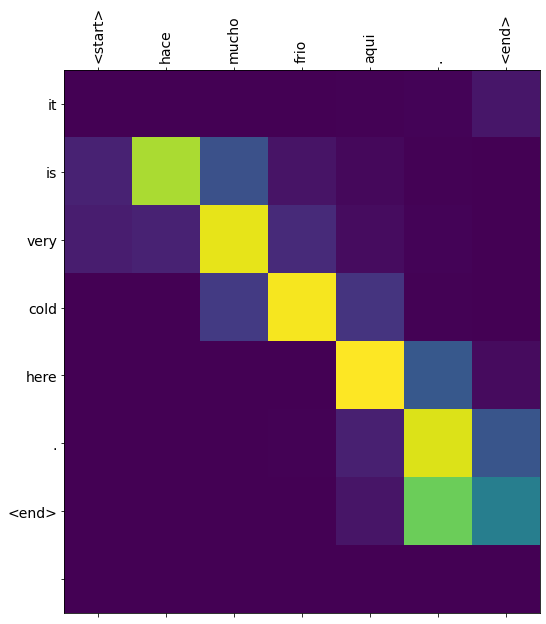

In [35]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


D:\Anaconda\envs\tf2.0\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
D:\Anaconda\envs\tf2.0\lib\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


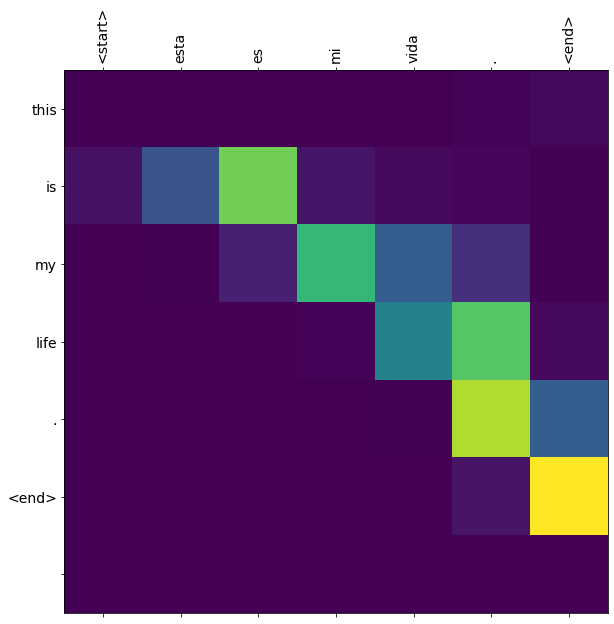

In [36]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


D:\Anaconda\envs\tf2.0\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
D:\Anaconda\envs\tf2.0\lib\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


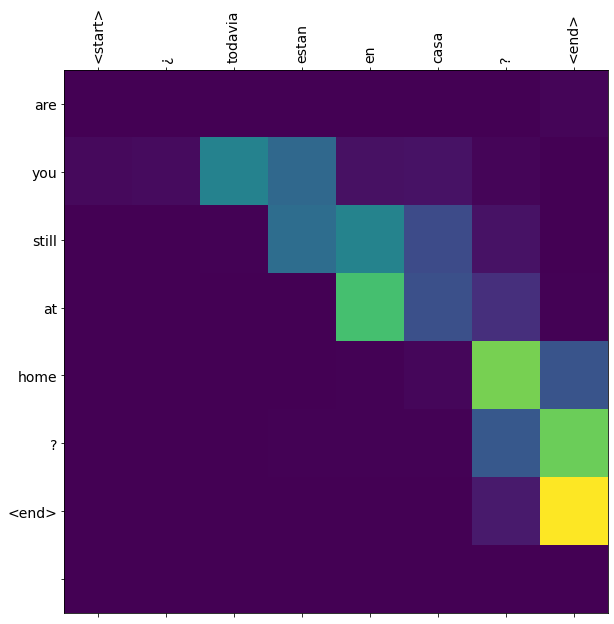

In [37]:
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to find out . <end> 


D:\Anaconda\envs\tf2.0\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
D:\Anaconda\envs\tf2.0\lib\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


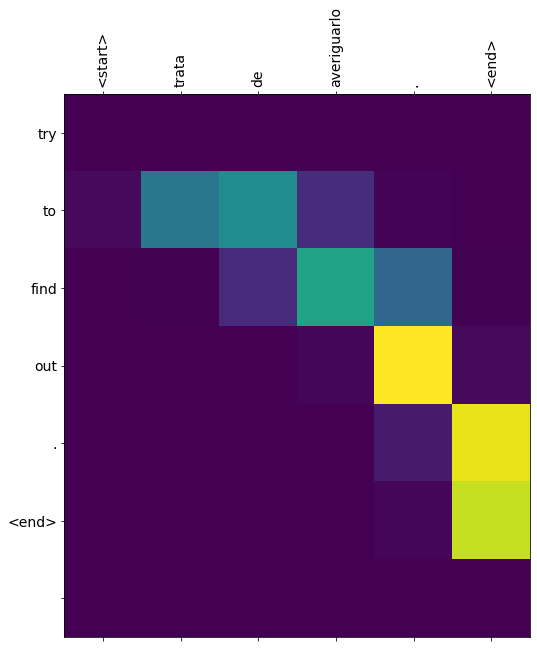

In [38]:
# 잘못된 번역
translate(u'trata de averiguarlo.')